Principal Notebook. Trata o dataset inteiro

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import StandardScaler

Utils

In [2]:
def cross_val(regressor, X, y, k=10):
    s = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
    results = cross_validate(regressor, X, y, cv=k, scoring=s)
    print(pd.DataFrame(results).mean())


def plot_results(regressor, X_train, y_train, X_test, y_test, y):
    model = regressor.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    errors = np.abs(y_pred - y_test)
    errors = errors / max(errors)

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, s=200 * errors, c=errors, alpha=0.7, marker='x')
    plt.ylim(0, max(y_pred.max(), y_test.max()))
    plt.xlim(0, max(y_pred.max(), y_test.max()))
    plt.xlabel('Value')
    plt.ylabel('Predicted')

    plt.plot([0, max(y)], [0, max(y)], c='gray')


# def correlation(dataset, threshold):
#     col_corr = set()
#     corr_matrix = dataset.corr()
#     for i in range(len(corr_matrix.columns)):
#         for j in range(i):
#             if abs(corr_matrix.iloc[i, j]) > threshold:
#                 col_name = corr_matrix.columns[i]
#                 col_corr.add(col_name)
#
#     return col_corr


def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                if (corr_matrix.columns[i] not in col_corr) and (corr_matrix.index.tolist()[j] not in col_corr):
                    col_name = corr_matrix.columns[i]
                    col_corr.add(col_name)
    return col_corr

Prepara dataset e remove features

In [3]:
data = pd.read_csv("../dataset/train.csv")

# casos em que essa condição é atendida nunca são selecionados
data = data[(data['warp_error'] / data['ref_frame_error']) < 0.65]

data.drop([
    'name',
    'cur_ref_count',
    'cur_showable_frame',
    'ref_showable_frame',
    'downsample_level',
    'num_refinements',
    'bit_depth',
    'selected'
    # 'ref_frame_error'
    # 'inliers_rate',
    # 'fast_error'
], axis=1, inplace=True)

# Remove os valores constantes (0 variancia)
var_thres = VarianceThreshold(threshold=0)
var_thres.fit(data)

constant_columns = [column for column in data.columns
                    if column not in data.columns[var_thres.get_support()]]

data.drop(constant_columns, axis=1)

df = pd.DataFrame(data, columns=data.columns)

df

,distance,num_ref_frames,cq_level,cur_order_hint,ref_ref_count,ref_order_hint,src_width,src_height,src_stride,frame,...,params_5,alpha,beta,gamma,delta,seg_count,ref_frame_error,fast_error,warp_error,inliers_rate
0,1,3,80,3,7,0,1280,720,1600,0,...,1.000836,64.0,-64.0,64.0,64.0,282,13583723,8002826,7070073,0.789596
1,1,1,80,2,5,0,1280,720,1600,0,...,1.000198,0.0,-64.0,64.0,0.0,312,12353545,6013827,4249018,0.995848
2,1,1,80,4,2,12,1280,720,1600,0,...,0.999844,0.0,0.0,0.0,0.0,340,13120077,8719772,4404826,0.993794
3,1,2,80,4,2,2,1280,720,1600,0,...,1.000341,0.0,-64.0,64.0,0.0,331,15298827,8171097,6394827,0.962245
4,1,1,80,5,2,12,1280,720,1600,0,...,0.999848,0.0,0.0,0.0,0.0,335,13184703,8545519,4495996,0.996654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12978,1,1,220,18,2,16,1920,1080,2240,0,...,1.000130,0.0,64.0,-64.0,0.0,159,2201413,1560646,1387306,0.298061
12979,1,1,220,18,2,15,1920,1080,2240,0,...,1.000140,0.0,-64.0,64.0,0.0,159,2233346,1753011,1412052,0.322563
12980,1,1,220,20,2,16,1920,1080,2240,0,...,1.000534,64.0,64.0,-64.0,64.0,164,2252645,1698476,1406832,0.317625
12981,1,2,220,20,1,15,1920,1080,2240,0,...,1.000172,0.0,0.0,0.0,0.0,103,2107298,748534,504552,0.199681


Separa os dados em treino e teste

In [4]:
X = data.drop(['warp_error'], axis=1)
y = data['warp_error']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

Correlação das features

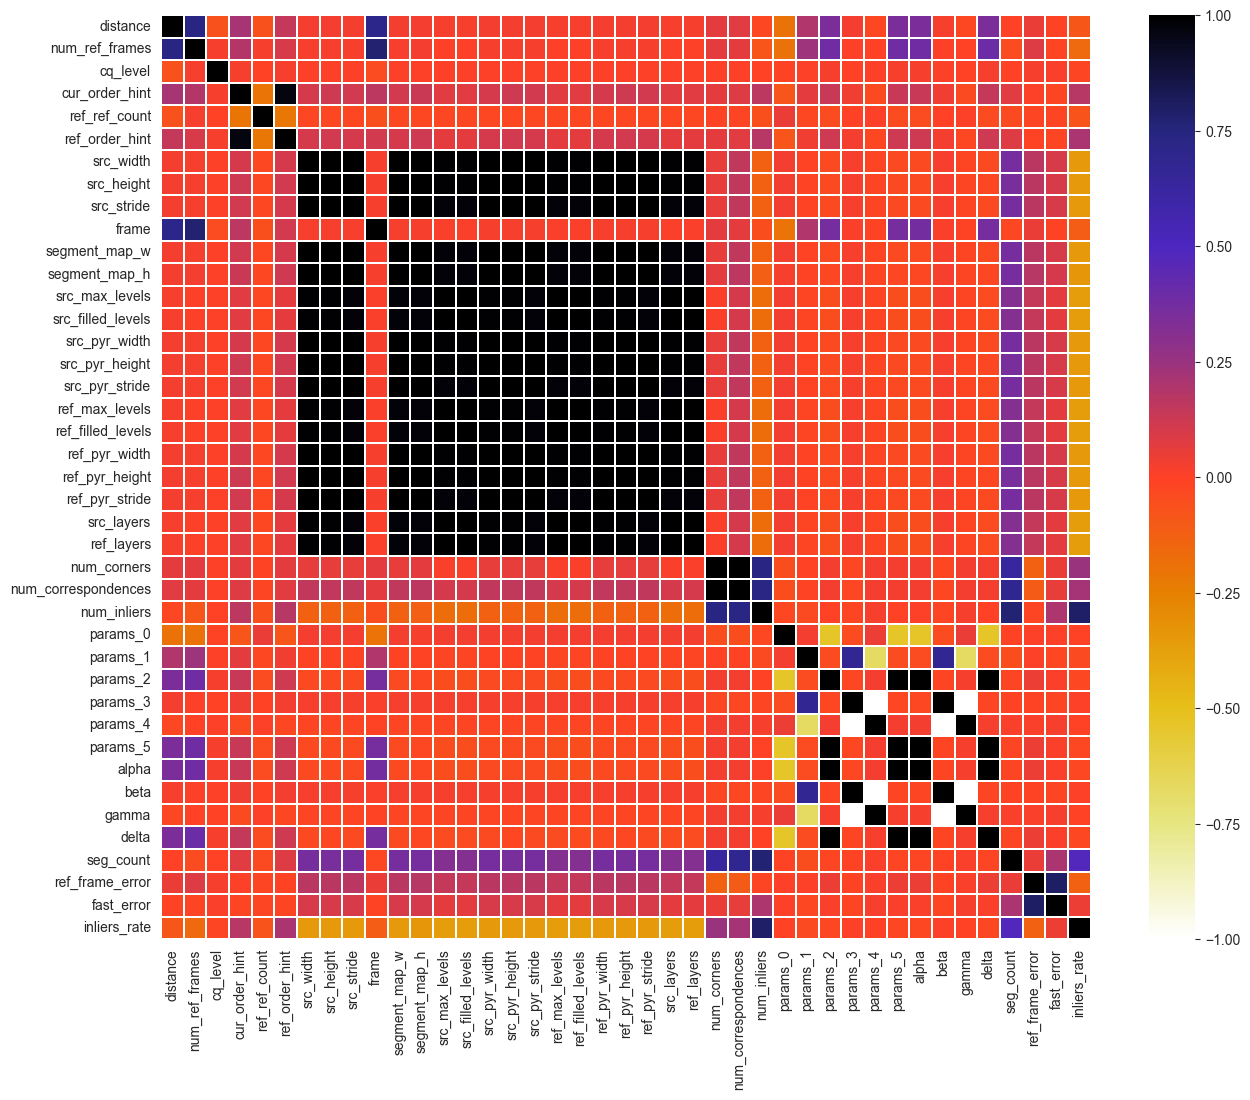

In [5]:
plt.figure(figsize=(15, 12))
sns.heatmap(X_train.corr(), cmap=plt.cm.CMRmap_r, linewidths=.1)
plt.show()

Features correlacionadas em mais de 90%

In [6]:
corr_features = correlation(X_train, 0.8)
corr_features = corr_features.difference(['fast_error', 'ref_frame_error'])
corr_features

{'alpha',
 'beta',
 'delta',
 'gamma',
 'num_correspondences',
 'params_4',
 'params_5',
 'ref_filled_levels',
 'ref_layers',
 'ref_max_levels',
 'ref_order_hint',
 'ref_pyr_height',
 'ref_pyr_stride',
 'ref_pyr_width',
 'segment_map_h',
 'segment_map_w',
 'src_filled_levels',
 'src_height',
 'src_layers',
 'src_max_levels',
 'src_pyr_height',
 'src_pyr_stride',
 'src_pyr_width',
 'src_stride'}

Remove features correlacionadas

In [7]:
X_train = X_train.drop(corr_features, axis=1)
X_test = X_test.drop(corr_features, axis=1)

Normaliza os dados

In [8]:
scaler = StandardScaler().fit(X_train)

X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)
X_normalized = scaler.transform(X.drop(corr_features, axis=1))

Correlação após remoção das features

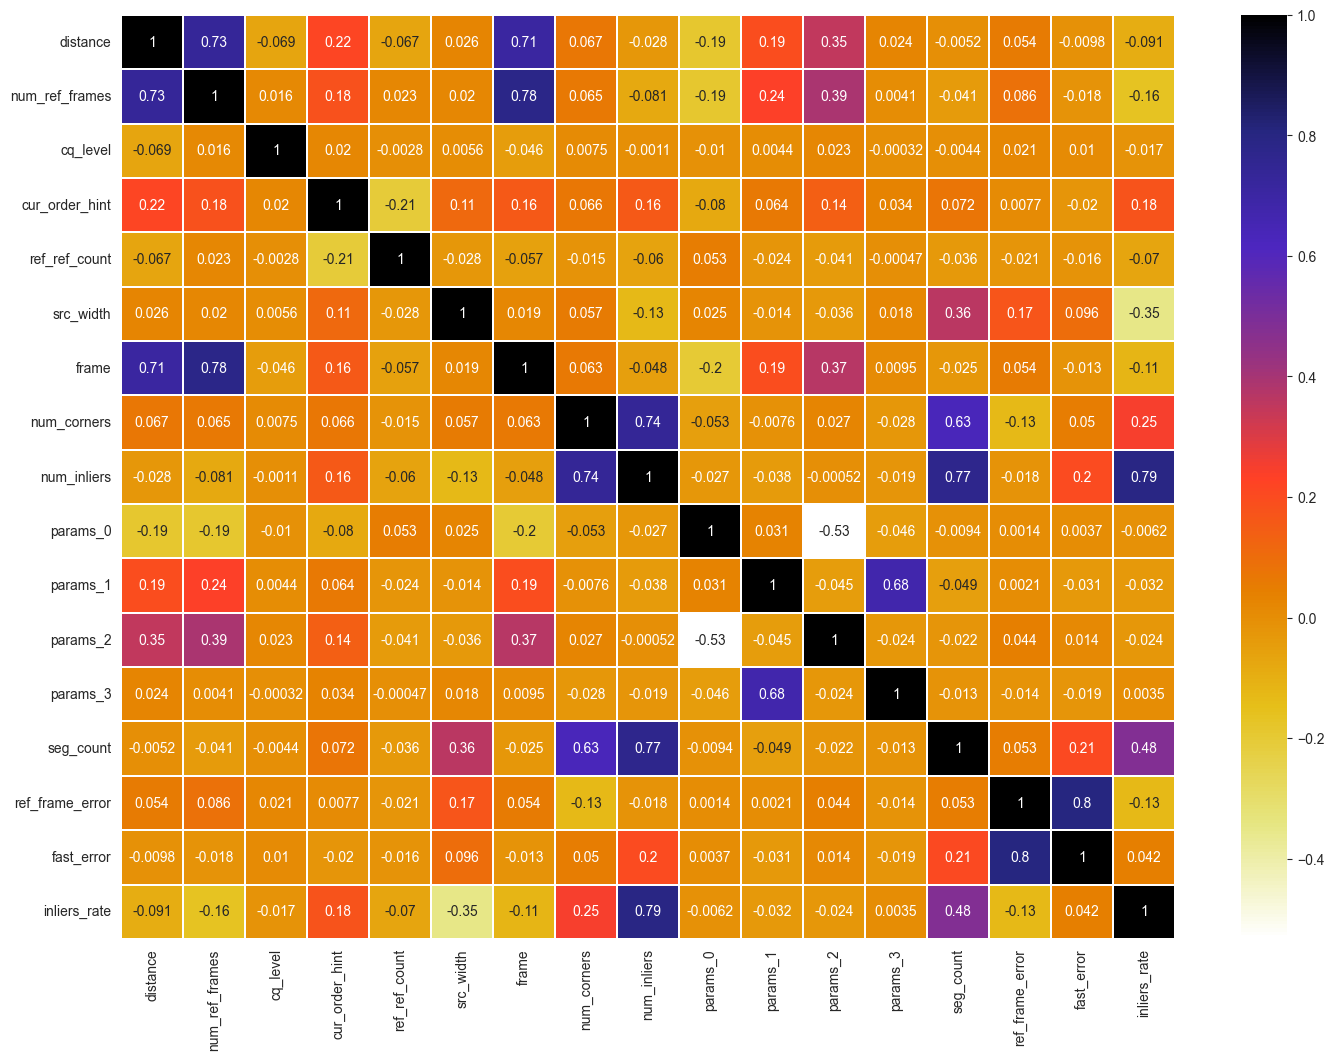

In [9]:
plt.figure(figsize=(17, 12))
sns.heatmap(X_train.corr(), cmap=plt.cm.CMRmap_r, annot=True, linewidths=.1)
plt.show()

Info sobre features mais relevantes

<Axes: >

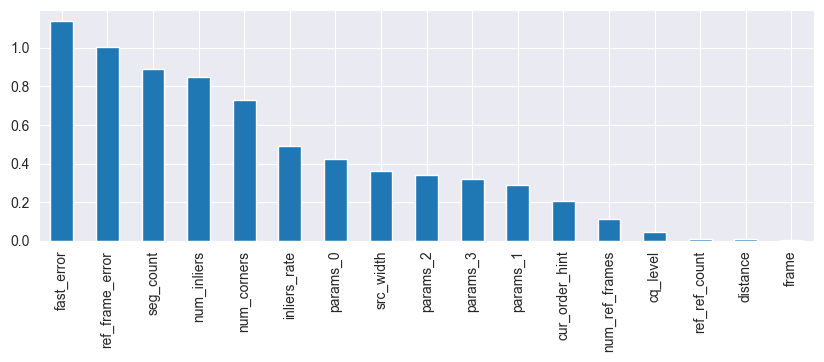

In [10]:
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False).plot.bar(figsize=(10,3))

Lista de features mais importantes baseadas no 1/4-percentil

In [11]:
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=50)
selected_top_columns.fit(X_train, y_train)

select_features = X_train.columns[selected_top_columns.get_support()]

select_features

Index(['src_width', 'num_corners', 'num_inliers', 'params_0', 'seg_count',
       'ref_frame_error', 'fast_error', 'inliers_rate'],
      dtype='object')

fit_time                                 0.045081
score_time                               0.005552
test_neg_mean_absolute_error       -429526.982190
test_neg_root_mean_squared_error   -737852.898084
test_r2                                  0.139656
dtype: float64


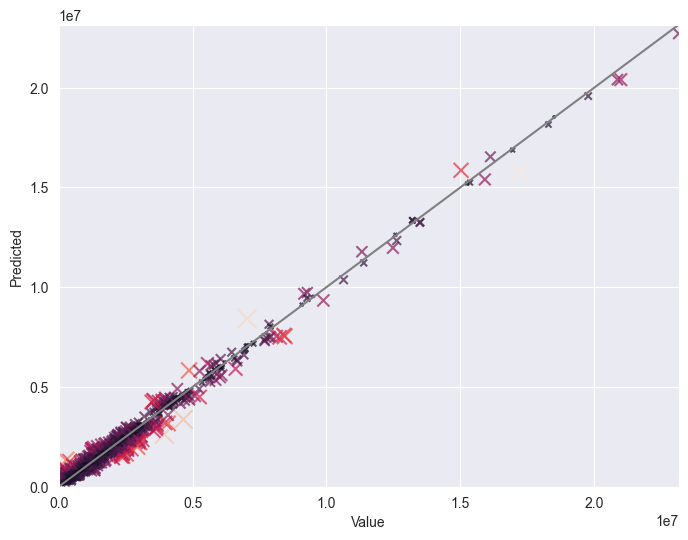

In [12]:
import xgboost as xg

xgb_r = xg.XGBRegressor(objective='reg:squarederror', learning_rate=0.25, n_estimators=20)

cross_val(xgb_r, X, y, 10)

plot_results(xgb_r, X_train_normalized, y_train, X_test_normalized, y_test, y)

fit_time                                 0.002502
score_time                               0.001337
test_neg_mean_absolute_error       -541470.604405
test_neg_root_mean_squared_error   -800935.091748
test_r2                                  0.759051
dtype: float64


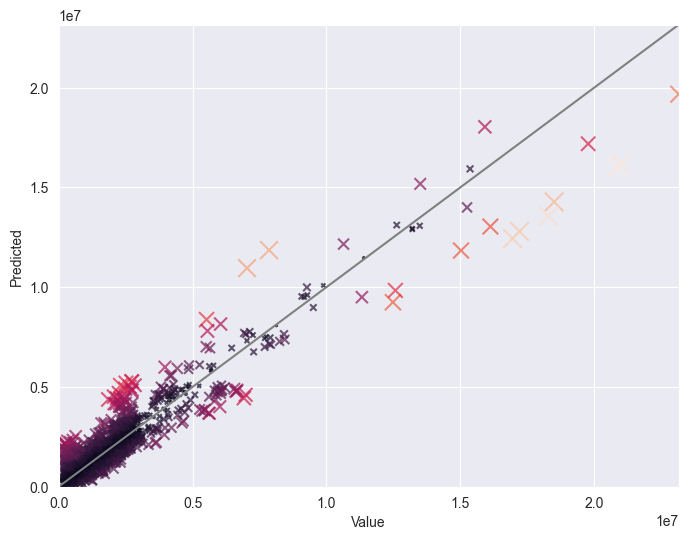

In [13]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

cross_val(lr, X_normalized, y, 3)

plot_results(lr, X_train_normalized, y_train, X_test_normalized, y_test, y)

fit_time                            1.281676e-01
score_time                          2.201843e-03
test_neg_mean_absolute_error       -5.526663e+05
test_neg_root_mean_squared_error   -1.012901e+06
test_r2                             5.970231e-01
dtype: float64


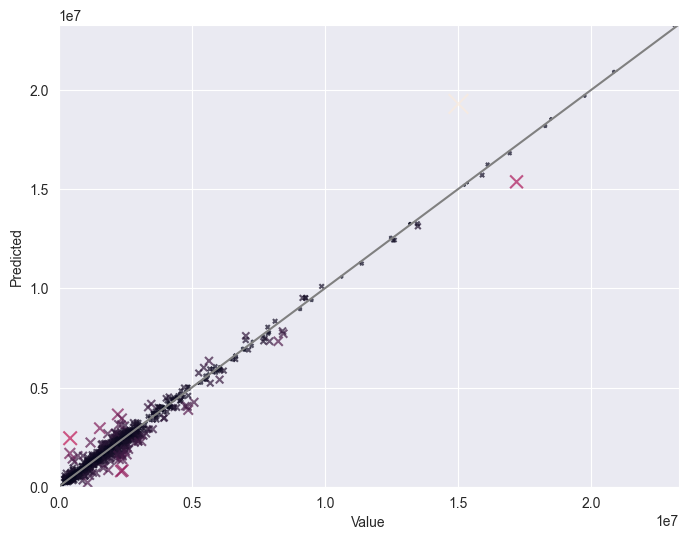

In [14]:
from sklearn import tree

tre = tree.DecisionTreeRegressor(random_state=42)

cross_val(tre, X, y, 5)

plot_results(tre, X_train, y_train, X_test, y_test, y)

In [15]:
# from sklearn.neural_network import MLPRegressor
#
# mlp = MLPRegressor(random_state=42, max_iter=500)
#
# cross_val(mlp, X, y, 10)
#
# plot_results(mlp, X_train, y_train, X_test, y_test, y)